In [1]:
import torch
from math import floor
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

from AnalyzeTools.models import autoregressive_integrated_moving_average, linear_regression, support_vector_regression, random_forest, gradient_boosting
from AnalyzeTools.prepare import data_split, model_eval, pathForSavingModels
from AnalyzeTools.preprocess import preprocessData
from AnalyzeTools.superModels import DEEPAR, TFT, RNN

params_path = './Models'

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 123


In [2]:
''' Read data '''
raw_file_name = '경략가격집계 - 소,돼지'
product = "pork-hot"
product_attribute = "경락가격"

_output = 'MAX_COST_AMT' # MIN_COST_AMT
default_exclude_cols = ['JUDGE_GUBN', 'JUDGE_BREED', 'JUDGE_SEX', 'SABLE_GUBN', 'ABATT_CODE']

df = pd.read_csv('../Data/beef/경략가격집계 - 소,돼지.csv', encoding = 'euc_kr', engine ='python').query("JUDGE_KIND == 2")

df = df.drop(default_exclude_cols, axis=1)
df = df.groupby(['STD_DATE']).mean().reset_index()
df['STD_DATE'] = df['STD_DATE'].apply(lambda x: "20" + "-".join(x.split("/")))

df, _input = preprocessData(df, 'STD_DATE', _output)


Feature scores:
                 Features        Scores
6  DEFECT_MAX_COST_AMT  6.811574e+10
1         MIN_COST_AMT  1.222592e+04
5  DEFECT_MIN_COST_AMT  1.222443e+04
2         SUM_COST_AMT  4.538033e+02
7  DEFECT_SUM_COST_AMT  4.537454e+02
8    DEFECT_SUM_WEIGHT  2.279391e+01
3           SUM_WEIGHT  2.277102e+01
4           DEFECT_CNT  1.084715e+01
0                  CNT  1.083094e+01

TOP K features:
   ['MIN_COST_AMT', 'SUM_COST_AMT', 'DEFECT_MIN_COST_AMT', 'DEFECT_MAX_COST_AMT']


In [3]:
# ''' Read data '''
# raw_file_name = '경략가격집계 - 소,돼지'
# product = "pork"
# product_attribute = "경락가격"

# _output = 'MAX_COST_AMT' # MIN_COST_AMT
# default_exclude_cols = ['JUDGE_GUBN', 'JUDGE_BREED', 'JUDGE_SEX', 'SABLE_GUBN', 'ABATT_CODE']

# df = pd.read_csv('../Data/beef/경략가격집계 - 소,돼지.csv', encoding = 'euc_kr', engine ='python').query("JUDGE_KIND == 2")

# df = df.drop(default_exclude_cols, axis=1)
# df = df.groupby(['STD_DATE']).mean().reset_index()
# df['STD_DATE'] = df['STD_DATE'].apply(lambda x: "20" + "-".join(x.split("/")))

# df, _input = preprocessData(df, 'STD_DATE', _output)

X_train: (2037, 3) y_train: (2037,) X_test: (510, 3) y_test: (510,)

Linear Regression
MAPE: 0.04591060412251238 R square: 0.7887015528604947


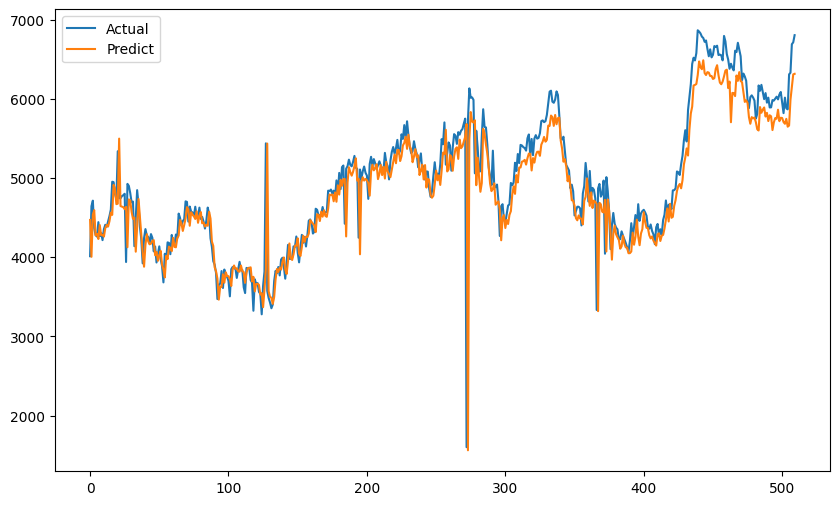


Support Vector Regression
MAPE: 0.14337941773897345 R square: -0.3186888451004184


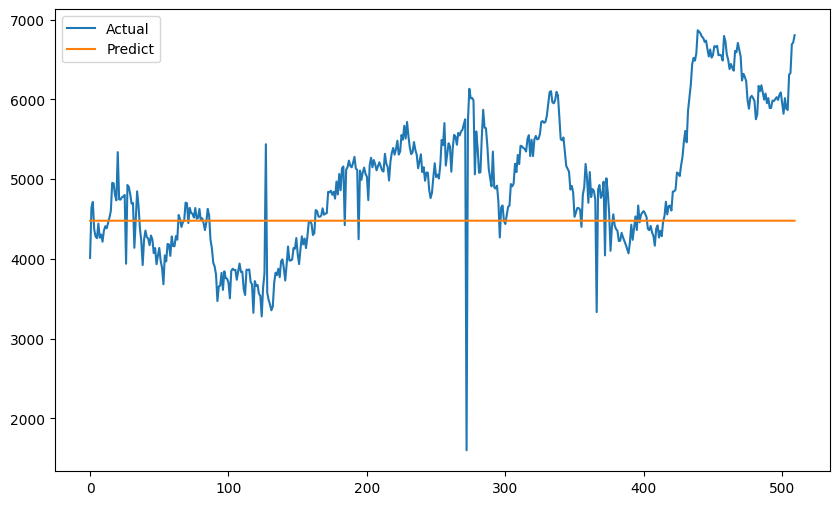


Random Forest
MAPE: 0.05828096446971005 R square: 0.688096214087855


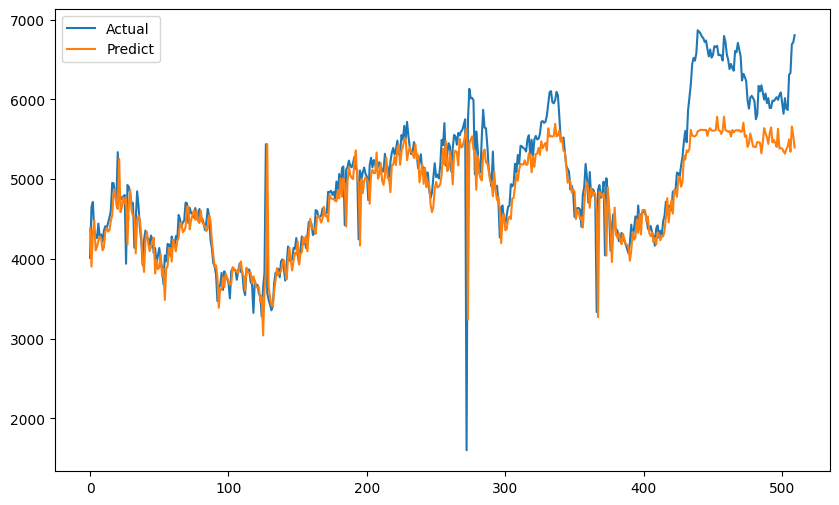


Gradient Boosting
MAPE: 0.057457362361913254 R square: 0.6691820863486762


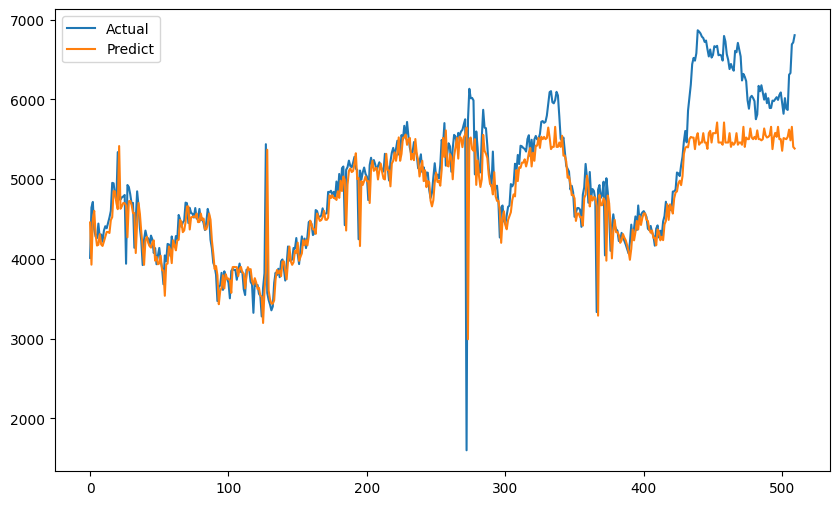

In [4]:
# prepare dataset for statistics and Macnhine models
ml_split_params = {'Model': 'ML', 'Future': 1}
X_train, X_test, y_train, y_test = data_split(df, input_cols=_input, output=_output, train_size=0.8, **ml_split_params)

''' Input data into models and Evaluate model results '''
ml_searchCV_params = {
    'base_dir': params_path,
    'product': product,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'save': True
}
stdout = True
vis = True

# print("\nARIMA")
# arima = autoregressive_integrated_moving_average(y_train)
# model_eval(y_test, arima.predict(n_periods=len(y_test), return_conf_int=False, aplha=0.05), stdout=stdout, vis=vis)

print("\nLinear Regression")
lr, _ = linear_regression(X_train, y_train)
model_eval(y_test, lr.predict(X_test), stdout=stdout, vis=vis)

print("\nSupport Vector Regression")
svr, _ = support_vector_regression(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, svr.predict(X_test), stdout=stdout, vis=vis)

print("\nRandom Forest")
rf, _ = random_forest(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, rf.predict(X_test), stdout=stdout, vis=vis)

print("\nGradient Boosting")
gb, _ = gradient_boosting(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, gb.predict(X_test), stdout=stdout, vis=vis)

In [5]:
data = df.copy()

data['time_idx'] = range(len(data))
data['group'] = product

training_cutoff = floor(len(data) * 0.8)

max_prediction_length = 1
max_encoder_length = 30 # 7, 14, 30, 60, 120
batch_size = 64

group = ['group']
time_varying_known_categoricals = ['month', 'week']
time_varying_unknown_categoricals = []
time_varying_known_reals = ['time_idx']
time_varying_unknown_reals = _input + [_output]


LSTM
MAPE: 0.039557941257953644 R square: 0.8654227409182393


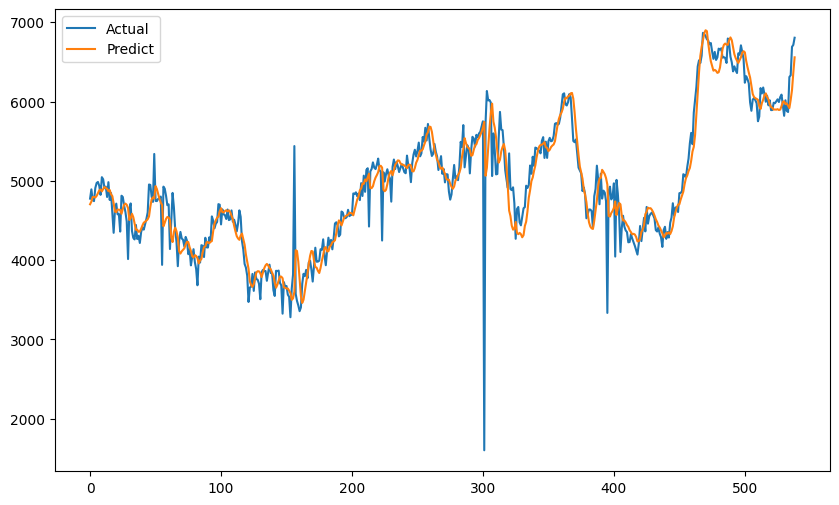

In [6]:
print("\nLSTM")
lstm, val_dataloader = RNN(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'LSTM'),
    'LSTM'
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = lstm.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)


GRU
MAPE: 0.037712838500738144 R square: 0.8682143887127423


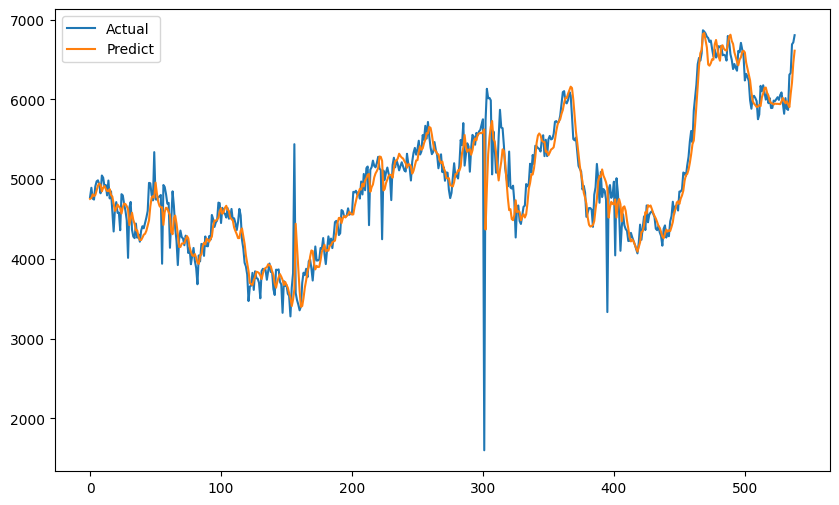

In [7]:
print("\nGRU")
gru, val_dataloader = RNN(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'GRU'),
    'GRU'
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = gru.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)


DeepAR
MAPE: 0.059296928346157074 R square: 0.7299028504147334


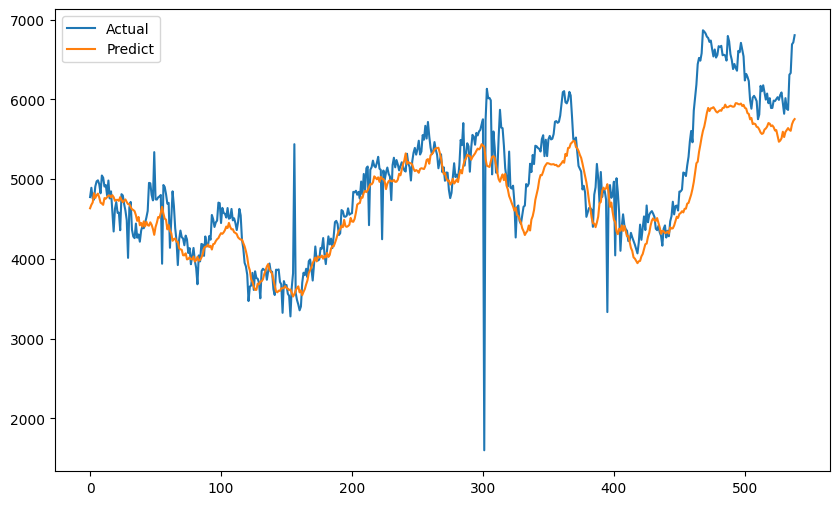

In [9]:
print("\nDeepAR")
deep_ar, val_dataloader = DEEPAR(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'DEEPAR'),
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = deep_ar.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)

In [ ]:
print("\nTFT")
tft, val_dataloader = TFT(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_unknown_categoricals,
    time_varying_known_categoricals,
    time_varying_known_reals,
    time_varying_unknown_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'TFT'),
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)